In [1]:
import sys
from pathlib import Path
#------------ Define the path to the folder containing your scripts
scripts_path = Path("/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/scripts").resolve()
#------------ Add this path to sys.path if it's not already included
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))
    
from train import*
from data_processing import*
from model import Model
from data_loader import*
from packages import*

In [2]:
# ---------------------------
# Configuration Parameters
# ---------------------------
basin = '01022500'            # 8-digit basin ID from the CAMELS dataset (modifiable)
hidden_size = 10              # Number of LSTM cells in the model
dropout_rate = 0.0            # Dropout rate for the final fully connected layer (0.0 to 1.0)
learning_rate = 1e-3          # Learning rate for the optimizer
sequence_length = 365         # Length (in days) of the meteorological record for each sample

# ---------------------------
# Dataset Setup
# ---------------------------
# Define date ranges for each dataset partition

# Training Data: from October 1, 1980 to September 30, 1995.
train_start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
train_end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[train_start_date, train_end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# For evaluation datasets, use the training means and standard deviations for normalization.
means = ds_train.get_means()
stds = ds_train.get_stds()

# Validation Data: from October 1, 1995 to September 30, 2000.
val_start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
val_end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[val_start_date, val_end_date],
                   means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test Data: from October 1, 2000 to September 30, 2010.
test_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
test_end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[test_start_date, test_end_date],
                    means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

In [3]:
# ---------------------------
# Model, Optimizer, and Loss Setup
# ---------------------------
# Initialize the LSTM model with the specified parameters and move it to the appropriate device.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)

# Setup the optimizer (Adam) for training the model.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error.
loss_func = nn.MSELoss()

# ---------------------------
# Summary and Debug Information
# ---------------------------
print("Configuration:")
print(f" Basin ID: {basin}")
print(f" Sequence length: {sequence_length}")
print(f" Hidden size: {hidden_size}")
print(f" Dropout rate: {dropout_rate}")
print(f" Learning rate: {learning_rate}")
print(f" Training period: {train_start_date.date()} to {train_end_date.date()}")
print(f" Validation period: {val_start_date.date()} to {val_end_date.date()}")
print(f" Test period: {test_start_date.date()} to {test_end_date.date()}")
print("\nModel summary:")
print(model)

Configuration:
 Basin ID: 01022500
 Sequence length: 365
 Hidden size: 10
 Dropout rate: 0.0
 Learning rate: 0.001
 Training period: 1980-10-01 to 1995-09-30
 Validation period: 1995-10-01 to 2000-09-30
 Test period: 2000-10-01 to 2010-09-30

Model summary:
Model(
  (lstm): LSTM(5, 10, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [4]:
n_epochs = 20 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")

Epoch 1: 100%|████████████████████| 20/20 [00:01<00:00, 19.16it/s, Loss: 0.7298]


Validation NSE: 0.06


Epoch 2: 100%|████████████████████| 20/20 [00:00<00:00, 21.26it/s, Loss: 0.7045]


Validation NSE: 0.10


Epoch 3: 100%|████████████████████| 20/20 [00:00<00:00, 21.16it/s, Loss: 0.4415]


Validation NSE: 0.16


Epoch 4: 100%|████████████████████| 20/20 [00:00<00:00, 21.07it/s, Loss: 0.5784]


Validation NSE: 0.23


Epoch 5: 100%|████████████████████| 20/20 [00:00<00:00, 21.03it/s, Loss: 0.4204]


Validation NSE: 0.32


Epoch 6: 100%|████████████████████| 20/20 [00:00<00:00, 21.06it/s, Loss: 0.5518]


Validation NSE: 0.40


Epoch 7: 100%|████████████████████| 20/20 [00:00<00:00, 21.16it/s, Loss: 0.7680]


Validation NSE: 0.46


Epoch 8: 100%|████████████████████| 20/20 [00:00<00:00, 21.04it/s, Loss: 0.5196]


Validation NSE: 0.51


Epoch 9: 100%|████████████████████| 20/20 [00:00<00:00, 21.18it/s, Loss: 0.6682]


Validation NSE: 0.54


Epoch 10: 100%|███████████████████| 20/20 [00:00<00:00, 21.12it/s, Loss: 0.4116]


Validation NSE: 0.57


Epoch 11: 100%|███████████████████| 20/20 [00:00<00:00, 20.71it/s, Loss: 0.3118]


Validation NSE: 0.59


Epoch 12: 100%|███████████████████| 20/20 [00:00<00:00, 20.40it/s, Loss: 0.3935]


Validation NSE: 0.61


Epoch 13: 100%|███████████████████| 20/20 [00:00<00:00, 21.07it/s, Loss: 0.2495]


Validation NSE: 0.62


Epoch 14: 100%|███████████████████| 20/20 [00:00<00:00, 21.13it/s, Loss: 0.2035]


Validation NSE: 0.63


Epoch 15: 100%|███████████████████| 20/20 [00:00<00:00, 21.22it/s, Loss: 0.3381]


Validation NSE: 0.63


Epoch 16: 100%|███████████████████| 20/20 [00:01<00:00, 19.01it/s, Loss: 0.2746]


Validation NSE: 0.65


Epoch 17: 100%|███████████████████| 20/20 [00:01<00:00, 18.29it/s, Loss: 0.5164]


Validation NSE: 0.65


Epoch 18: 100%|███████████████████| 20/20 [00:00<00:00, 20.88it/s, Loss: 0.2107]


Validation NSE: 0.65


Epoch 19: 100%|███████████████████| 20/20 [00:00<00:00, 21.03it/s, Loss: 0.1275]


Validation NSE: 0.67


Epoch 20: 100%|███████████████████| 20/20 [00:00<00:00, 21.13it/s, Loss: 0.1170]


Validation NSE: 0.66


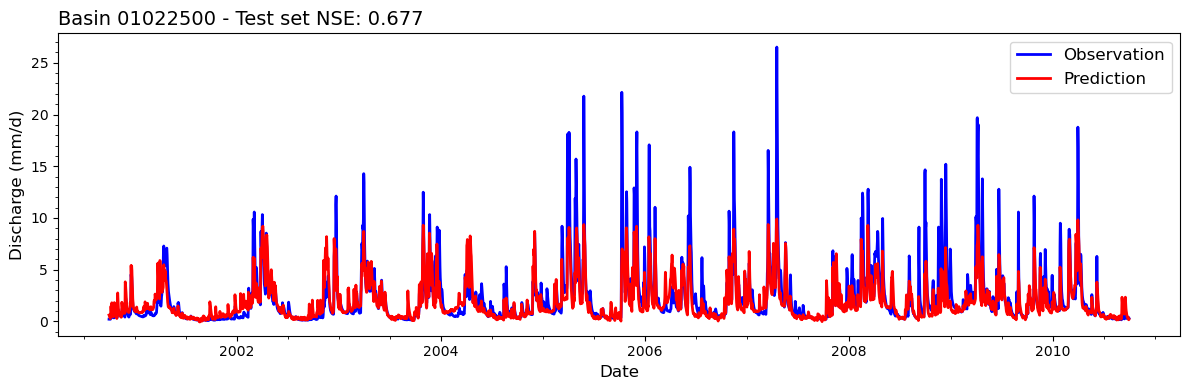

In [5]:
# Evaluate the model on the test set
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Create a date range for plotting based on the test set dates
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

# Generate a standard time series plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="Observation", lw=2, color="blue")
ax.plot(date_range, preds, label="Prediction", lw=2, color="red")
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}", fontsize=14, loc = "left")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Discharge (mm/d)", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='x')
ax.minorticks_on()
plt.tight_layout()
plt.show()

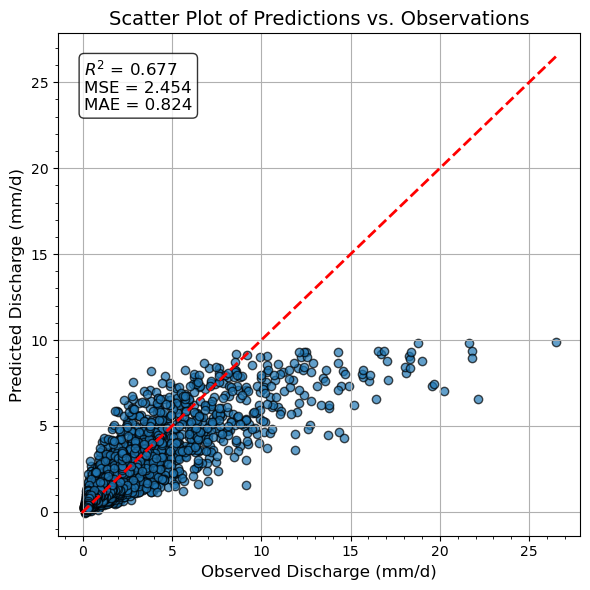

In [6]:
# --- Scatter Plot of Predictions vs. Observations ---
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate metrics
r2 = r2_score(obs, preds)
mse = mean_squared_error(obs, preds)
mae = mean_absolute_error(obs, preds)

# --- Figure 2: Scatter Plot of Predictions vs. Observations ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.scatter(obs, preds, alpha=0.7, edgecolor='k')

# Plot a 1:1 line for reference
min_val = np.min([obs.min(), preds.min()])
max_val = np.max([obs.max(), preds.max()])
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Set axis labels and title
ax2.set_xlabel("Observed Discharge (mm/d)", fontsize=12)
ax2.set_ylabel("Predicted Discharge (mm/d)", fontsize=12)
ax2.set_title("Scatter Plot of Predictions vs. Observations", fontsize=14)
ax2.minorticks_on()
ax2.grid()

# Annotate the plot with metrics inside the plot area
metrics_text = f"$R^2$ = {r2:.3f}\nMSE = {mse:.3f}\nMAE = {mae:.3f}"
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.show()


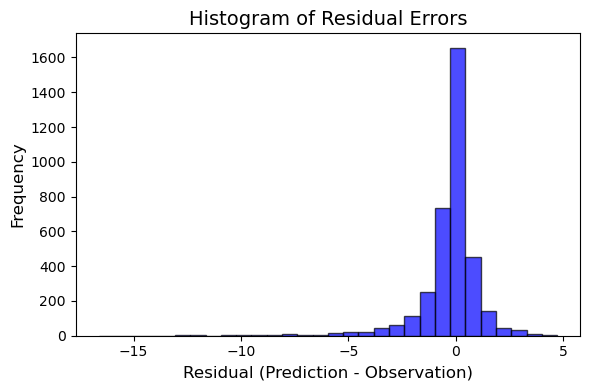

In [7]:
# --- Histogram of Residual Errors ---
residuals = preds - obs
fig3, ax3 = plt.subplots(figsize=(6, 4))
ax3.hist(residuals, bins=30, color='blue', edgecolor='k', alpha=0.7)
ax3.set_xlabel("Residual (Prediction - Observation)", fontsize=12)
ax3.set_ylabel("Frequency", fontsize=12)
ax3.set_title("Histogram of Residual Errors", fontsize=14)
fig3.tight_layout()
# ax3.grid()
plt.show()

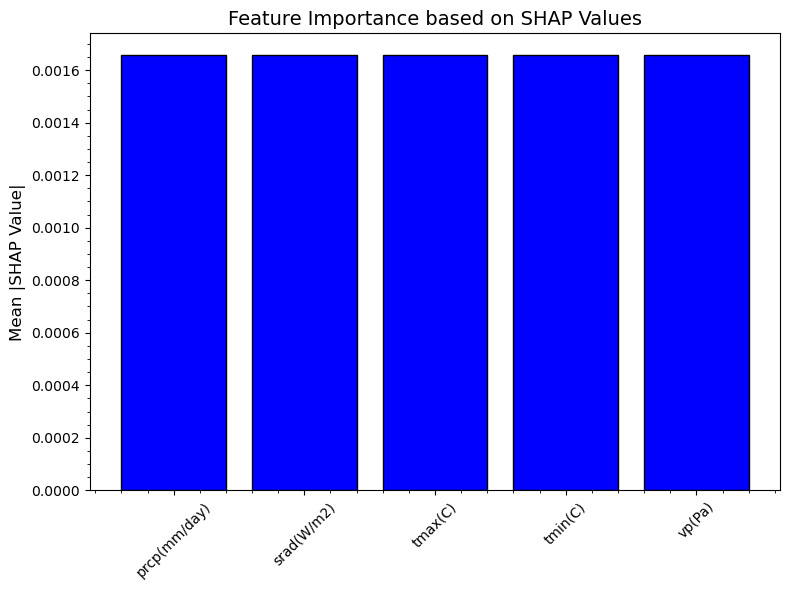

In [8]:
# ------------------------------
# SHAP Explanation for the Model
# ------------------------------

# Select a subset of training samples as the background for SHAP.
# ds_train.x is assumed to be a torch.Tensor of shape (N, sequence_length, features)
background = ds_train.x[:50].to(DEVICE)

# Select some test samples for explanation (e.g., first 50 samples)
X_test = ds_test.x[:100].to(DEVICE)

# Create a DeepExplainer using the background samples.
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the test samples.
# Set check_additivity=False to bypass the additivity check.
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Extract the array from the list. The shape is (n_samples, sequence_length, n_features).
shap_vals = shap_values[0]
if isinstance(shap_vals, torch.Tensor):
    shap_vals = shap_vals.detach().cpu().numpy()

# Aggregate SHAP values over the time (sequence) dimension:
# Average the absolute SHAP values over the sequence length for each feature.
abs_shap = np.abs(shap_vals).mean(axis=1)  # Shape: (n_samples, n_features)
# Then average over all samples to get one value per feature.
mean_shap_per_feature = abs_shap.mean(axis=0)  # Shape: (n_features,)

# Define feature names corresponding to your input features.
feature_names = ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'vp(Pa)']

# ------------------------------
# Plot the SHAP Feature Importances
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(feature_names, mean_shap_per_feature, color='blue', edgecolor='k')
ax.set_ylabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance based on SHAP Values', fontsize=14)
ax.minorticks_on()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
